In [2]:
from glob import glob
import pandas as pd
import spacy
from spacy import displacy
import nltk
from nltk import sent_tokenize
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

In [3]:

subtitles_paths = sorted(glob("../data/Subtitles/*.ass"))

scripts = []
episode_num = []

nlp = spacy.load("en_core_web_trf")

In [4]:

def get_ners(script):
    script_sentences = sent_tokenize(script)
    ner_output = []

    for sentence in script_sentences:
        doc = nlp(sentence)
        ners = set()
        for ent in doc.ents:
            if ent.label_ == 'PERSON':
                full_name = ent.text
                first_name = full_name.split(' ')[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output

In [5]:

for path in subtitles_paths:
    with open(path, 'r', encoding='utf-8', errors='ignore') as file:
        lines = file.readlines()
        lines = lines[27:]
        rows = [",".join(line.split(',')[9:]) for line in lines]

    rows = [line.replace("\\N", ' ') for line in rows]
    script = " ".join(rows)

    episode = int(path.split('-')[1].split('.')[0].strip())

    scripts.append(script)
    episode_num.append(episode)

df = pd.DataFrame.from_dict({'episode': episode_num, 'script': scripts})
df['ners'] = df['script'].apply(get_ners)

window = 10
entity_relationship = []

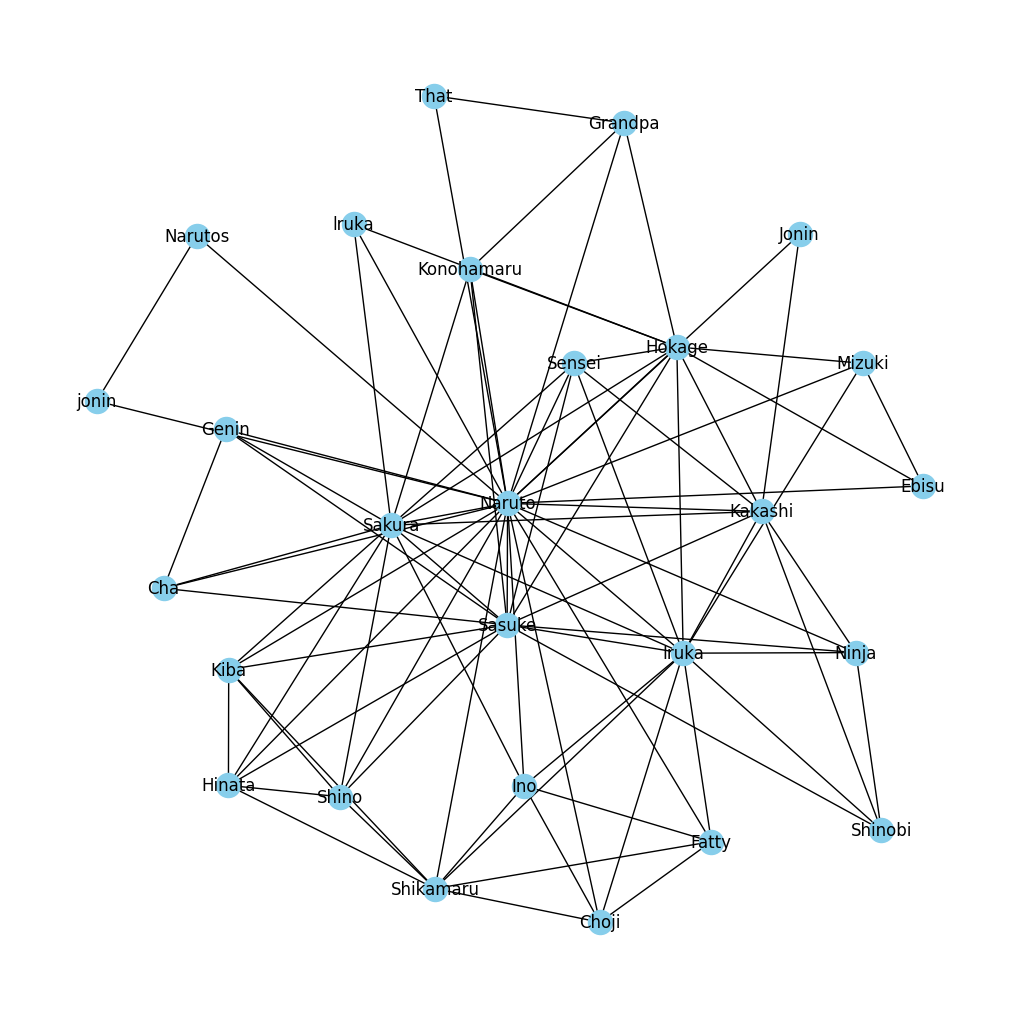

naruto.html


In [6]:

for row in df['ners']:
    previous_entities_in_window = []

    for sentence in row:
        previous_entities_in_window.append(sentence)
        previous_entities_in_window = previous_entities_in_window[-10:]

        previous_entities_flattened = sum(previous_entities_in_window, [])

        for entity in sentence:
            for entity_in_window in previous_entities_flattened:
                if entity != entity_in_window:
                    entity_rel = sorted([entity, entity_in_window])
                    entity_relationship.append(entity_rel)

relationship_df = pd.DataFrame({'value': entity_relationship})
relationship_df['source'] = relationship_df['value'].apply(lambda x: x[0])
relationship_df['target'] = relationship_df['value'].apply(lambda x: x[1])
relationship_df = relationship_df.groupby(['source', 'target']).count().reset_index()
relationship_df = relationship_df.sort_values('value', ascending=False)
relationship_df = relationship_df.head(200)

G = nx.from_pandas_edgelist(relationship_df, source="source", target="target", edge_attr="value", create_using=nx.Graph())

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

net = Network(notebook=True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("naruto.html")
